In [14]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
from visualizations import bias_variance_demo, cross_validation_demo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../Data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [187]:
import pandas as pd
# we can't use pandas but we are just showing the total dataframe
pd.DataFrame(tX).head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,...,16.824,-0.277,258.733,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,160.937,68.768,103.235,48.146,2.107,225.885,-0.244,3.473,2.078,125.157,...,44.704,-1.916,164.546,46.226,0.725,1.158,47.902,-0.01,-0.002,46.226
2,112.406,162.172,125.953,35.635,2.107,225.885,-0.244,3.148,9.336,197.814,...,54.283,-2.186,260.414,44.251,2.053,-2.028,47.902,-0.01,-0.002,44.251
3,143.905,81.417,80.943,0.414,2.107,225.885,-0.244,3.310,0.414,75.968,...,31.082,0.060,86.062,65.561,0.000,-0.033,47.902,-0.01,-0.002,0.000
4,175.864,16.915,134.805,16.405,2.107,225.885,-0.244,3.891,16.405,57.983,...,2.723,-0.871,53.131,65.561,0.000,-0.033,47.902,-0.01,-0.002,0.000


In [ ]:
tX.shape

# Data Pre-Processing

### removing -999s

In [16]:
for col in tX.T:
    med = np.median(col[col != -999])
    col[col == -999] = med

### removing 22nd Index

In [17]:
model_index = tX[:, 22] # model index is useful later on to select only the indices where categorical variable = 0,1,2,3

#remove model index column from tx
tX = np.delete(tX, 22, 1)

In [127]:
model_index.shape

(250000,)

In [128]:
model_index

array([ 2.,  1.,  1., ...,  1.,  0.,  0.])

## Build list of polynomials

We built a tX with 10 degrees, then extract tX as we need... 

# don't need to run tX10! just run [211], it is saved.

In [87]:
# building a polynomial matrix of degree 10
tX_10 = build_poly3(tX,10)

In [210]:
import pickle
pickle.dump( tX_10, open( "tX_10.p", "wb" ) )

In [211]:
tX_10 = pickle.load( open( "tX_10.p", "rb" ) )

In [89]:
tX_10.shape

(250000, 290)

In [119]:
Fused = np.c_[y, tX_10] # combining tX_10 with y

In [129]:
# builds the tX specific polynomial degree
def build_poly_d(tX_all_degree, degree):
    index = list()
    index.append(0)
    for i in range(0,29): # tX.shape[1] is 29, 
        for d in range(1,degree+1): # up to degree 10 for example
            index.append(i*10+d) # [1,11,...,281]
    return tX_all_degree[:,index]

In [212]:
max_degree = 10
tX_list = list()
# takes a long time to run, run only once!!!
for degree in range(1,max_degree+1):
    tX_list.append(build_poly_d(Fused, degree))

In [136]:
tX_list[9].shape # polynomial with degrees 1 2 3... 10

(250000, 291)

In [104]:
build_poly_d(tX_10,2).shape

[1, 2, 11, 12, 21, 22, 31, 32, 41, 42, 51, 52, 61, 62, 71, 72, 81, 82, 91, 92, 101, 102, 111, 112, 121, 122, 131, 132, 141, 142, 151, 152, 161, 162, 171, 172, 181, 182, 191, 192, 201, 202, 211, 212, 221, 222, 231, 232, 241, 242, 251, 252, 261, 262, 271, 272, 281, 282]


(250000, 58)

In [ ]:
Fused = np.c_[y, tX_10]

### Building Polynomial Matrix

In [6]:
# x is one column
def build_poly_one_column(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    size = (x.shape[0])*(degree)
    phi = list()
    
    for i in range(0, x.shape[0]):
        for j in range(1, degree+1):
            index = j + i*(degree+1)
            phi.append(np.power(x[i], j))
            
    return np.array(phi).reshape((1, size))

#polyX = np.full((tX.shape[0], tX.shape[1] * (degree+1)), 0.0)
# tX is a multidimensional array
def build_poly3(tX, degree):
    polyX = list()
    for row in tX:
        polyX.append(build_poly_one_column(row, degree))

    PolyXNP = np.array(polyX)
    PolyXNP2 = PolyXNP.reshape((PolyXNP.shape[0], PolyXNP.shape[2]))

    return PolyXNP2
    #Standardize
    PolyXNP2 = standardize(PolyXNP2)
    

### Standardizing Matrix Columns

In [150]:
# standardize such that the mean is 0 and standard deviation is 1.
# X is a multi-dimensional array
def standardize2(X):
    X = (X - np.mean(X)) / np.std(X)
    X = np.hstack((np.ones((X.shape[0],1)), X)) # adding column of ones for the first column
    return X

## Cross Validation

In [204]:
def cross_validation_rr(y, x, k_indices, k, lambda_):
    """return the loss of ridge regression."""
    
    # empty array for computing the mean for each hold
    loss_tr_arr = [] 
    loss_te_arr = [] 
    
    for k in range(0,k):
        # get k'th subgroup in test, others in train
        x_test = x[k_indices[k],:]
        y_test = y[k_indices[k]]
        x_train = np.delete(x, k_indices[k], axis=0)
        y_train = np.delete(y, k_indices[k])
        
        # ridge regression
        loss_tr, weights = ridge_regression(y_train, x_train, lambda_)
        loss_te = compute_loss(y_test,x_test,weights)
        rmse_tr = np.sqrt(2*loss_tr)
        rmse_te = np.sqrt(2*loss_te)
        
        loss_tr_arr.append(rmse_tr)
        loss_te_arr.append(rmse_te)
        
    # calculate the loss for train and test data
    loss_tr = np.sqrt(np.mean(np.power(loss_tr_arr,2)))
    loss_te = np.sqrt(np.mean(np.power(loss_te_arr,2)))
    
    return loss_tr, loss_te

In [205]:
from plots import cross_validation_visualization
def cross_validation_demo(tX, y, k_fold):
    """Generating the cv visualization for one example."""
    seed = 1
    lambdas = np.logspace(-5, 2, 20)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    # cross validation: TODO
    for lambda_ in lambdas:
        loss_tr, loss_te = cross_validation_rr(y, tX, k_indices, k_fold, lambda_)
        rmse_tr.append(loss_tr)
        rmse_te.append(loss_te)
    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

## One Model

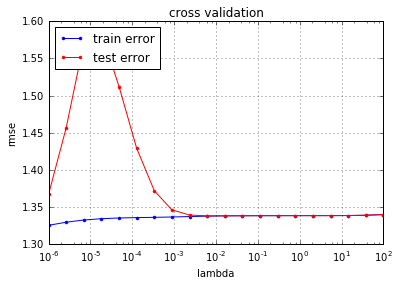

In [189]:
cross_validation_demo(x0,y0,10)

## Four Model

## Degree 3

See below!! Right now x0,x1,...y0,y1 all defined manually

This is what we need to choose best lambda for ridge regression.
We also need to choose degree and k-fold. Maybe do research on theory with how to select lambda, degree, and k for k-fold?

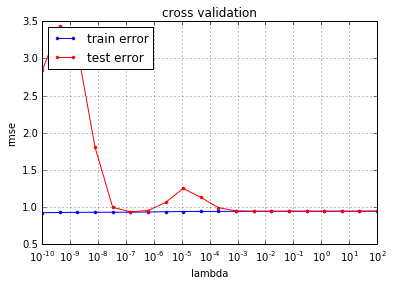

In [206]:
cross_validation_demo(x0,y0,10)

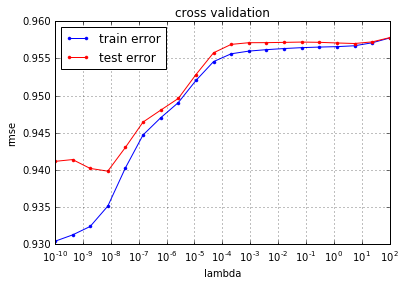

In [207]:
# model 1, the error is extremely small.
# lambda = 10
cross_validation_demo(x1,y1,10)

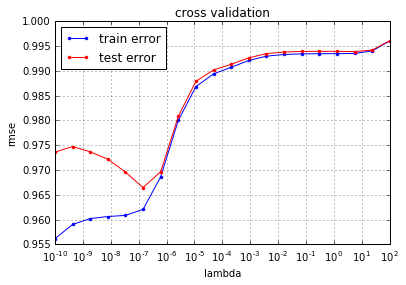

In [208]:
cross_validation_demo(x2,y2,10)

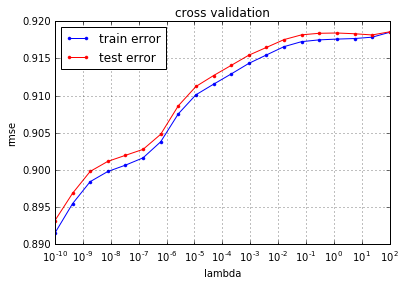

In [209]:
cross_validation_demo(x3,y3,10)

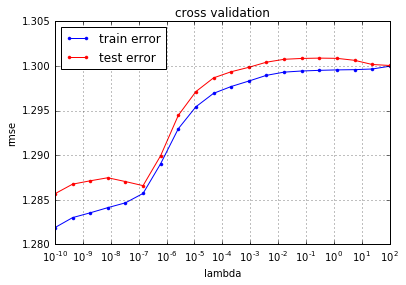

In [196]:
cross_validation_demo(x3_4,y3_4,10)

In [188]:
# without split
x = tX_list[3] # degree 3
y0 = x[:,0]
x0 = x[:,1:x.shape[1]]
x0 = standardize2(x0)

In [151]:
# degree 3
Fused_0 = tX_list[3][model_index == 0.0] # degree 3
y0 = Fused_0[:,0]
x0 = Fused_0[:,1:Fused_0.shape[1]]
x0 = standardize2(x0)

Fused_1 = tX_list[3][model_index == 1.0] # degree 3
y1 = Fused_1[:,0]
x1 = Fused_1[:,1:Fused_1.shape[1]]
x1 = standardize2(x1)

Fused_2 = tX_list[3][model_index == 2.0] # degree 3
y2 = Fused_2[:,0]
x2 = Fused_2[:,1:Fused_2.shape[1]]
x2 = standardize2(x2)

Fused_3 = tX_list[3][model_index == 3.0] # degree 3
y3 = Fused_3[:,0]
x3 = Fused_3[:,1:Fused_3.shape[1]]
x3 = standardize2(x3)

In [ ]:
# degree 4
Fused_0 = tX_list[4][model_index == 0.0] # degree 3
y0 = Fused_0[:,0]
x0 = Fused_0[:,1:Fused_0.shape[1]]
x0 = standardize2(x0)

Fused_1 = tX_list[4][model_index == 1.0] # degree 3
y1 = Fused_1[:,0]
x1 = Fused_1[:,1:Fused_1.shape[1]]
x1 = standardize2(x1)

Fused_2 = tX_list[4][model_index == 2.0] # degree 3
y2 = Fused_2[:,0]
x2 = Fused_2[:,1:Fused_2.shape[1]]
x2 = standardize2(x2)

Fused_3_4 = tX_list[4][model_index == 3.0] # degree 3
y3_4 = Fused_3[:,0]
x3_4 = Fused_3[:,1:Fused_3.shape[1]]
x3_4 = standardize2(x3_4)

In [195]:
Fused_3_4 = tX_list[4][model_index == 3.0] # degree 3
y3_4 = Fused_3_4[:,0]
x3_4 = Fused_3_4[:,1:Fused_3_4.shape[1]]
x3_4 = standardize2(x3_4)

In [197]:
Fused_3_1 = tX_list[1][model_index == 3.0] # degree 3
y3_1 = Fused_3_1[:,0]
x3_1 = Fused_3_1[:,1:Fused_3_1.shape[1]]
x3_1 = standardize2(x3_1)

In [ ]:
# degree 3
Fused_0 = tX_list[3][model_index == 0.0] # degree 3
y0 = Fused_0[:,0]
x0 = Fused_0[:,1:Fused_0.shape[1]]
x0 = standardize2(x0)